# Black Oil Table Extension
## Based on approach outlined in SPE 109596, with following modifications
1. Incorporating phase densities as a second set of converging parameters
2. Extrapolating viscosity as a linear function of density rather than creating an EOS to fit.
3. Extrapolating with quadratic equations in log-log space, honoring last slopes seen in table data

Load your BOT saturated table data, enter surface fluid phase densities, then iterate on Pk and convergence density until monotonic extrapolated parameters result (Bg often the troublesome one)

In [117]:
%matplotlib inline
import pandas as pd
import scipy.interpolate
import matplotlib.pyplot as plt
import math
from scipy.stats import linregress
from sympy import symbols, Eq, solve
import tabulate
from tabulate import tabulate

def log10(x):
    return math.log(x)/math.log(10)

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [118]:
sheet_name = 'PVTO&PVTG_example.xlsx'
dfPVTO = pd.read_excel (sheet_name, sheet_name='PVTO')
Bo = dfPVTO['Bo'].tolist()
OneOnBo = [1/x for x in Bo]
uo = dfPVTO['uo'].tolist()
Bouo = [Bo[i]*uo[i] for i in range(len(uo))]
OneOnBouo = [1/x for x in Bouo]
dfPVTO['OneOnBo'] = OneOnBo
dfPVTO['OneOnBouo'] = OneOnBouo

dfPVTG = pd.read_excel (sheet_name, sheet_name='PVTG')
Bg = dfPVTG['Bg'].tolist()
OneOnBg = [1/x for x in Bg]
ug = dfPVTG['ug'].tolist()
Bgug = [Bg[i]*ug[i] for i in range(len(ug))]
OneOnBgug = [1/x for x in Bgug]
dfPVTG['OneOnBg'] = OneOnBg
dfPVTG['OneOnBgug'] = OneOnBgug

## Enter your surface fluid densities here. 
You can overwrite the ST_MWO relationship with actual MW if you have it.
last_row parameter controls which row from the end of the BOT table is used for the first point in extrapolation. -3 would mean third from the end etc.

In [119]:
# Define surface fluid properties and constants to use later
ST_DENO = 49.87 #lb/cuft    
ST_DENG = 0.0689 #lb/cuft
ST_MWO = 240-2.22*( (141.5/(ST_DENO/62.428)) -131.5) # Correlation to estimate MW of ST Oil
Lo = 5.6146 * ST_DENO / ST_MWO
Lg = 1/0.3795
Mult = 1000/5.6146
Co = Mult*Lo/Lg
ST_MWG =ST_DENG*1000/Lg

# Define which row from the end should be used as starting point
last_row = -1

In [120]:
# Create single saturated pressure dataframe
Pb = dfPVTO['Pb'].tolist()
Pd = dfPVTG['P'].tolist()

Psat =[]
for p in Pb:
    if p in Pd:
        Psat.append(p)

filtered_PVTO = dfPVTO[dfPVTO['Pb'].isin(Psat)].copy()
filtered_PVTG = dfPVTG[dfPVTG['P'].isin(Psat)].copy()

PVT = pd.concat([filtered_PVTO, filtered_PVTG], axis=1)
del PVT['Pb']
PVT['ko'] =(1 +PVT['Rs'] * Mult/Co) / (1 + 1 / (Co * PVT['Rv'] / Mult))
PVT['kg'] = (1 +Co / (PVT['Rs'] * Mult)) / (1 + Co * (PVT['Rv'] / Mult))
PVT['Rs_dim'] = Co*(1-PVT['ko'])/(PVT['kg']-1)
PVT['rs_dim'] = PVT['ko']*(PVT['kg']-1)/(Co*PVT['kg']*(1-PVT['ko']))
PVT['xo'] = Co/((PVT['Rs']*Mult)+Co)
PVT['xgi'] = 1 - PVT['xo']
PVT['yo'] = Lo*PVT['Rv']/(Lg+Lo*PVT['Rv'])
PVT['ygi'] = 1 - PVT['yo']
PVT['MWo'] = ST_MWO * PVT['xo'] + ST_MWG*(1-PVT['xo'])
PVT['MWg'] = ST_MWO* PVT['yo'] +ST_MWG*(1- PVT['yo'])
PVT['DENO'] = (ST_DENO + ST_DENG * PVT['Rs'] * Mult)/PVT['Bo']
PVT['DENG'] = (ST_DENG + ST_DENO *(PVT['Rv'] / Mult))/(PVT['Bg'] / Mult)
PVT['vo'] = PVT['MWo'] / PVT['DENO']
PVT['vg'] = PVT['MWg'] / PVT['DENG']

In [121]:
# Function to return y value for given x, between two pairs of defined points
# While honoring slope seen at first pair of points
# y = a*x**2 + b*x + c
# dy/dx = Slope = 2*a*x + b
def quad_extrap(slope,x1,y1,x2,y2,x):
    b = (slope*(x2**2-x1**2)+2*x1*(y1-y2))/(x1-x2)**2
    a = (slope - b)/(2*x1)
    c = y1 - a*x1**2 - b*x1
    return a*x**2 +b*x + c

def update_and_plot(Pk, PVT, last_row, Denk):
    
    DenO_slope = log10(PVT['DENO'].iloc[last_row] / PVT['DENO'].iloc[last_row-1]) / log10(PVT['P'].iloc[last_row] / PVT['P'].iloc[last_row-1])    
    DenG_slope = log10(PVT['DENG'].iloc[last_row] / PVT['DENG'].iloc[last_row-1]) / log10(PVT['P'].iloc[last_row] / PVT['P'].iloc[last_row-1])
    
    kO_slope = log10(PVT['ko'].iloc[last_row] / PVT['ko'].iloc[last_row-1])/log10(PVT['P'].iloc[last_row] / PVT['P'].iloc[last_row-1])
    kG_slope = log10(PVT['kg'].iloc[last_row] / PVT['kg'].iloc[last_row-1])/log10(PVT['P'].iloc[last_row] / PVT['P'].iloc[last_row-1])

    x1 = log10(PVT['P'].iloc[last_row])
    x2 = log10(Pk)
    
    DENO_ext, DENG_ext, ko_ext, kg_ext, p_ext = [[] for i in range(5)]
    n_ext = 50
    deltap = (Pk - PVT['P'].iloc[last_row])/(n_ext-1)
    
    for i in range(n_ext):        
        p_ext.append(PVT['P'].iloc[last_row] + i*deltap)
        if p_ext[-1] == Pk:
            p_ext[-1] = p_ext[-1] - 1
        DENO_ext.append(10**(quad_extrap(DenO_slope,x1,log10(PVT['DENO'].iloc[last_row]),x2,log10(Denk),log10(p_ext[-1]))))
        DENG_ext.append(10**(quad_extrap(DenG_slope,x1,log10(PVT['DENG'].iloc[last_row]),x2,log10(Denk),log10(p_ext[-1]))))
        ko_ext.append(10**(quad_extrap(kO_slope,x1,log10(PVT['ko'].iloc[last_row]),x2,0,log10(p_ext[-1]))))
        kg_ext.append(10**(quad_extrap(kG_slope,x1,log10(PVT['kg'].iloc[last_row]),x2,0,log10(p_ext[-1]))))
    
    # Now calculate Bo's and Bg's in extrapolated region
    Bo_extrap, Bg_extrap, Rs_extrap, Rv_extrap = [[] for i in range(4)]
    table=[]
    header=['Pressure','Bg', 'Rv', 'DENG'] 
    non_monotonic = False
    for i, pres in enumerate(p_ext):
        Rs_extrap.append(Co*(1-ko_ext[i])/(kg_ext[i]-1)/Mult)
        Rv_extrap.append( ko_ext[i]*(kg_ext[i]-1)/(Co*kg_ext[i]*(1-ko_ext[i]))*Mult)
        Bo_extrap.append((ST_DENO+ST_DENG*Rs_extrap[i]*Mult)/DENO_ext[i])
        Bg_extrap.append((ST_DENG+ST_DENO*Rv_extrap[i]/Mult)*Mult/DENG_ext[i])
        table.append([pres, Bg_extrap[i],Rv_extrap[i],DENG_ext[i]])
        if i > 0:
            if Bg_extrap[-1] >= Bg_extrap[-2]:
                non_monotonic = True
            
    OneOnBgExtrap = [1/x for x in Bg_extrap]
    #print(tabulate(table,headers=header))
    PVT_extrap = pd.DataFrame()
    PVT_extrap['P'] = p_ext
    PVT_extrap['Rs'] = Rs_extrap
    PVT_extrap['Rv'] = Rv_extrap
    PVT_extrap['Bo'] = Bo_extrap
    PVT_extrap['Bg'] = Bg_extrap
    PVT_extrap['DENO'] = DENO_ext
    PVT_extrap['DENG'] = DENG_ext
    
    to_remove = -1 - last_row
    if to_remove == 0:
        bg = PVT['Bg'].tolist()
        bo = PVT['Bo'].tolist()
        p = PVT['P'].tolist()
        Rs = PVT['Rs'].tolist()
        Rv = PVT['Rv'].tolist()
    else: # Remove data that was ignored
        bg = PVT['Bg'].tolist()[:-to_remove]
        bo = PVT['Bo'].tolist()[:-to_remove]
        p = PVT['P'].tolist()[:-to_remove]
        Rs = PVT['Rs'].tolist()[:-to_remove]
        Rv = PVT['Rv'].tolist()[:-to_remove]
    
    bg_ext = [bg[-2]]
    bo_ext = [bo[-2]]
    p_ext = [p[-2]]
    Rs_ext = [Rs[-2]]
    Rv_ext = [Rv[-2]]
    
    bg_ext += PVT_extrap['Bg'].tolist()
    bo_ext += PVT_extrap['Bo'].tolist()
    p_ext += PVT_extrap['P'].tolist()
    Rs_ext += PVT_extrap['Rs'].tolist()
    Rv_ext += PVT_extrap['Rv'].tolist()
    
    dBgdPo = [(bg[i]-bg[i-1])/(p[i]-p[i-1]) for i in range(1,len(p))]
    dBodPo = [(bo[i]-bo[i-1])/(p[i]-p[i-1]) for i in range(1,len(p))]
    dRsdPo = [(Rs[i]-Rs[i-1])/(p[i]-p[i-1]) for i in range(1,len(p))]
    dRvdPo = [(Rv[i]-Rv[i-1])/(p[i]-p[i-1]) for i in range(1,len(p))]
    TcOil = [1/bo[i+1]*(-dBodPo[i]+dRsdPo[i]*(bg[i+1]-Rv[i+1]*bo[i+1])/(1-Rs[i+1]*Rv[i+1])) for i in range(len(p)-1)]
    TcGas = [1/bg[i+1]*(-dBgdPo[i]+dRvdPo[i]*(bo[i+1]-Rs[i+1]*bg[i+1])/(1-Rs[i+1]*Rv[i+1])) for i in range(len(p)-1)]
    p.pop(0) # Remove first pressure point so list lengths match
    
    dBgdPo_ext = [(bg_ext[i]-bg_ext[i-1])/(p_ext[i]-p_ext[i-1]) for i in range(1,len(p_ext))]
    dBodPo_ext = [(bo_ext[i]-bo_ext[i-1])/(p_ext[i]-p_ext[i-1]) for i in range(1,len(p_ext))]
    dRsdPo_ext = [(Rs_ext[i]-Rs_ext[i-1])/(p_ext[i]-p_ext[i-1]) for i in range(1,len(p_ext))]
    dRvdPo_ext = [(Rv_ext[i]-Rv_ext[i-1])/(p_ext[i]-p_ext[i-1]) for i in range(1,len(p_ext))]
    TcOil_ext = [1/bo_ext[i+1]*(-dBodPo_ext[i]+dRsdPo_ext[i]*(bg_ext[i+1]-Rv_ext[i+1]*bo_ext[i+1])/(1-Rs_ext[i+1]*Rv_ext[i+1])) for i in range(len(p_ext)-1)]
    TcGas_ext = [1/bg_ext[i+1]*(-dBgdPo_ext[i]+dRvdPo_ext[i]*(bo_ext[i+1]-Rs_ext[i+1]*bg_ext[i+1])/(1-Rs_ext[i+1]*Rv_ext[i+1])) for i in range(len(p_ext)-1)]
    p_ext.pop(0) # Remove first pressure point so list lengths match
    
    nx = ny = 1                                                                                                                                                                                                                                                         
    dxs = 8.0                                                                                                                              
    dys = 5.5                                                                                                                              
    i = j = 0                  
    fig, ax = plt.subplots(ny, nx, sharey = False, figsize=(dxs*nx, dys*ny), squeeze=False ) # squeeze = False ensures 2 x 1 does not get converted to 1D                                                                                
    fig.subplots_adjust(top=0.95, bottom = 0.05, left = 0.05, right = 0.95)   
    ax[i,j].title.set_text('Compressibility vs Pressure')
    ax[i,j].plot(p, TcGas, label='Gas Table', color='red', linewidth=2,marker='o',markersize=5)  
    ax[i,j].plot(p, TcOil, label='Oil Table', color='green', linewidth=2,marker='o',markersize=5)   
    ax[i,j].plot(p_ext, TcGas_ext, label='Gas Extrap', color='red', linewidth=2,linestyle = '--')  
    ax[i,j].plot(p_ext, TcOil_ext, label='Oil Extrap', color='green', linewidth=2,linestyle = '--') 
    ax[i,j].grid(True, which="both") 
    ax[i,j].set_yscale('log')
    ax[i,j].set_xscale('log')                                                                                                               
    ax[i,j].set_xlabel('Pressure (psia)')                                                                                        
    ax[i,j].set_ylabel('Compressibility (psi-1)')                                                                                                    
    ax[i,j].legend()  
    plt.plot()
    
    nx = 2                                                                                                                                 
    ny = 3    
    numplots = 6
                                                                                                                               
    dxs = 8.0                                                                                                                              
    dys = 5.5                                                                                                                              
    i = j = 0                  
    fig, ax = plt.subplots(ny, nx, sharey = False, figsize=(dxs*nx, dys*ny), squeeze=False ) # squeeze = False ensures 2 x 1 does not get converted to 1D                                                                                                                              
                                                                                              
    fig.subplots_adjust(top=0.95, bottom = 0.05, left = 0.05, right = 0.95)   
    ax[i,j].title.set_text('Densities')
    ax[i,j].plot(PVT['P'], PVT['DENO'], label='Oil Density', color='green', linewidth=2,marker='o',markersize=5)  
    ax[i,j].plot(PVT['P'], PVT['DENG'], label='Gas Density', color='red', linewidth=2,marker='o',markersize=5)       
    ax[i,j].plot(p_ext, DENO_ext, label='Extrap Oil Density', color='green', linewidth=2,markersize=5,linestyle = '--')  
    ax[i,j].plot(p_ext, DENG_ext, label='Extrap Gas Density', color='red', linewidth=2,markersize=5,linestyle = '--')   
    ax[i,j].grid(True, which="both") 
    #ax[i,j].set_yscale('log')
    #ax[i,j].set_xscale('log')                                                                                                               
    ax[i,j].set_xlabel('Pressure (psia)')                                                                                        
    ax[i,j].set_ylabel('Density (lb/cuft)')                                                                                                    
    ax[i,j].legend()                                                                                                                   
    if j < nx-1:                                                                                                                       
        j+=1                                                                                                                                                                                                                                                 
    else:                                                                                                                              
        j = 0                                                                                                                          
        i += 1
    ax[i,j].title.set_text('Kis')
    ax[i,j].plot(PVT['P'], PVT['ko'], label='Ko', color='green', linewidth=2,marker='o',markersize=5)   
    ax[i,j].plot(PVT['P'], PVT['kg'], label='Kg', color='red', linewidth=2,marker='o',markersize=5) 
    ax[i,j].plot(p_ext, ko_ext, label='Extrap Ko', color='green', linewidth=2,markersize=5,linestyle = '--')   
    ax[i,j].plot(p_ext, kg_ext, label='Extrap Kg', color='red', linewidth=2,markersize=5,linestyle = '--')  
    ax[i,j].grid(True, which = "both") 
    ax[i,j].set_yscale('log')
    ax[i,j].set_xscale('log')   
    ax[i,j].set_xlabel('Pressure (psia)')                                                                                        
    ax[i,j].set_ylabel('Ki')                                                                                                    
    ax[i,j].legend() 
    
    if j < nx-1:                                                                                                                       
        j+=1                                                                                                                                                                                                                                                 
    else:                                                                                                                              
        j = 0                                                                                                                          
        i += 1
    ax[i,j].title.set_text('Oil FVF (Bo)')
    ax[i,j].plot(PVT['P'], PVT['Bo'], label='PVT Table', color='green', linewidth=2,marker='o',markersize=5)  
    ax[i,j].plot(p_ext, Bo_extrap, label='Extrapolated', color='green', linewidth=2,linestyle = '--') 
    ax[i,j].grid(True, which="both")                                                                                                              
    ax[i,j].set_xlabel('Pressure (psia)')                                                                                        
    ax[i,j].set_ylabel('Bo (rb/stb)')                                                                                                    
    ax[i,j].legend() 
    if j < nx-1:                                                                                                                       
        j+=1                                                                                                                                                                                                                                                 
    else:                                                                                                                              
        j = 0                                                                                                                          
        i += 1
    if non_monotonic:
        ax[i,j].title.set_text('Gas FVF (1/Bg) - NON MONOTONIC')
    else:
        ax[i,j].title.set_text('Gas FVF (1/Bg)')
    ax[i,j].plot(PVT['P'], PVT['OneOnBg'], label='PVT Table', color='green', linewidth=2,marker='o',markersize=5)  
    ax[i,j].plot(p_ext, OneOnBgExtrap, label='Extrapolated', color='green', linewidth=2,linestyle = '--') 
    ax[i,j].grid(True, which="both")                                                                                                              
    ax[i,j].set_xlabel('Pressure (psia)')                                                                                        
    ax[i,j].set_ylabel('1/Bg (mscf/rb)') 
    #ax[i,j].set_yscale('log')
    ax[i,j].legend() 
    
    if j < nx-1:                                                                                                                       
        j+=1                                                                                                                                                                                                                                                 
    else:                                                                                                                              
        j = 0                                                                                                                          
        i += 1
        
    ax[i,j].title.set_text('Solution GOR (Rs)')
    ax[i,j].plot(PVT['P'], PVT['Rs'], label='PVT Table', color='red', linewidth=2,marker='o',markersize=5)  
    ax[i,j].plot(p_ext, Rs_extrap, label='Extrapolated', color='red', linewidth=2,linestyle = '--') 
    ax[i,j].grid(True, which="both")                                                                                                              
    ax[i,j].set_xlabel('Pressure (psia)')                                                                                        
    ax[i,j].set_ylabel('Solution GOR (mscf/stb)')                                                                                                    
    ax[i,j].legend()                                                                                                                   
    if j < nx-1:                                                                                                                       
        j+=1                                                                                                                                                                                                                                                 
    else:                                                                                                                              
        j = 0                                                                                                                          
        i += 1
    ax[i,j].title.set_text('Vaporized OGR (Rv)')
    ax[i,j].plot(PVT['P'], PVT['Rv'], label='PVT Table', color='green', linewidth=2,marker='o',markersize=5)  
    ax[i,j].plot(p_ext, Rv_extrap, label='Extrapolated', color='green', linewidth=2,linestyle = '--') 
    ax[i,j].grid(True, which="both")                                                                                                              
    ax[i,j].set_xlabel('Pressure (psia)')                                                                                        
    ax[i,j].set_ylabel('Vaporized OGR (stb/mscf)')                                                                                                    
    ax[i,j].legend() 

    plt.show()

    return PVT_extrap

## Iterate on Pk (Convergence pressure) and Denk (Convergence Density)
Run, and plots below will update. Check monotonicity of results, especially gas FVF

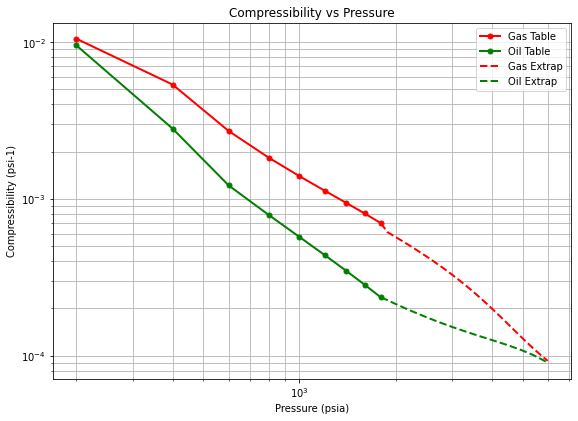

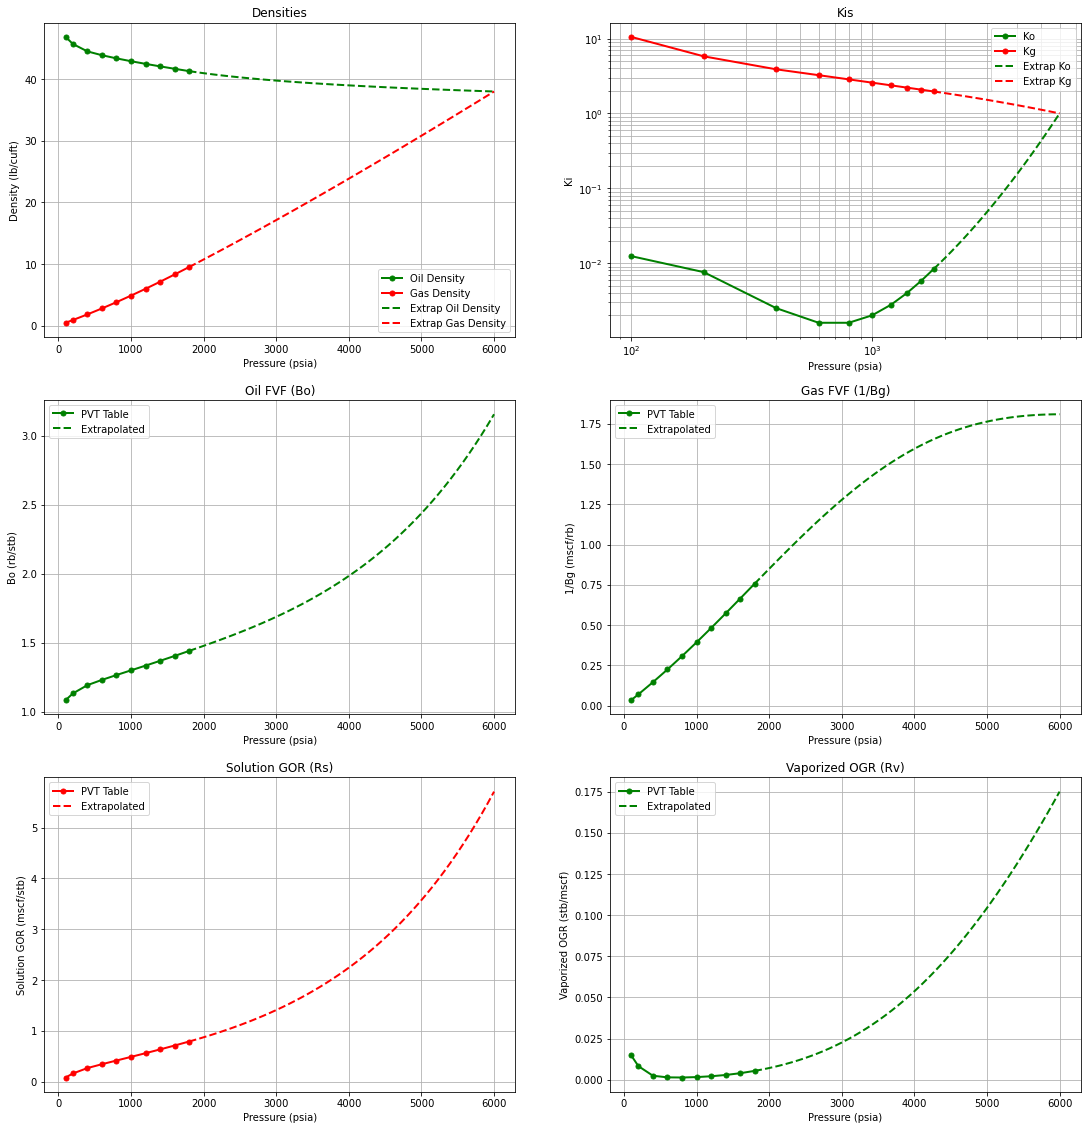

In [127]:
# Define Pk and density intersection
Pk = 6000
Denk = 38
last_row = -1

PVT_extrap = update_and_plot(Pk, PVT, last_row, Denk)

## Fit viscosities to straight line relationships as a function of density.
Ensure that (a) they intersect at Pk and (b) there is no jump from the last value given in the BOT

<function matplotlib.pyplot.show(*args, **kw)>

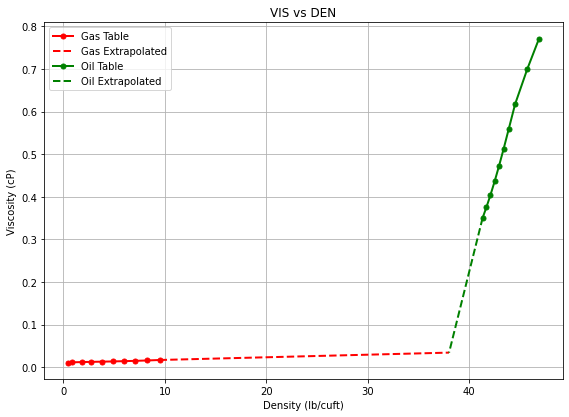

In [128]:
#den = PVT['DENG'].tolist() + PVT['DENO'].tolist()
#vis = PVT['ug'].tolist() + PVT['uo'].tolist()

DenK = PVT_extrap['DENO'].iloc[-1]
ugfit =linregress(PVT['DENG'], PVT['ug'] ) 
uk = ugfit[0] * DenK + ugfit[1]
ug_slope = (uk - PVT['ug'].iloc[last_row])/(DenK - PVT['DENG'].iloc[last_row])
ug_int = uk - ug_slope*DenK
uo_slope = (uk - PVT['uo'].iloc[last_row])/(DenK - PVT['DENO'].iloc[last_row])
uo_int = uk - uo_slope*DenK

PVT_extrap['uo'] = uo_slope*PVT_extrap['DENO']+uo_int
PVT_extrap['ug'] = ug_slope*PVT_extrap['DENG']+ug_int

nx = 1                                                                                                                                 
ny = 1                                                                                                                            
dxs = 8.0                                                                                                                              
dys = 5.5                                                                                                                              
i = j = 0                  
fig, ax = plt.subplots(ny, nx, sharey = False, figsize=(dxs*nx, dys*ny), squeeze=False ) # squeeze = False ensures 2 x 1 does not get converted to 1D                                                                                
fig.subplots_adjust(top=0.95, bottom = 0.05, left = 0.05, right = 0.95)   
ax[i,j].title.set_text('VIS vs DEN')
ax[i,j].plot(PVT['DENG'], PVT['ug'], label='Gas Table', color='red', linewidth=2,marker='o',markersize=5)  
ax[i,j].plot(PVT_extrap['DENG'], PVT_extrap['ug'], label='Gas Extrapolated', color='red', linewidth=2,linestyle='--') 
ax[i,j].plot(PVT['DENO'], PVT['uo'], label='Oil Table', color='green', linewidth=2,marker='o',markersize=5)   
ax[i,j].plot(PVT_extrap['DENO'], PVT_extrap['uo'], label='Oil Extrapolated', color='green', linewidth=2,linestyle='--') 
ax[i,j].grid(True, which="both") 
#ax[i,j].set_yscale('log')
#ax[i,j].set_xscale('log')                                                                                                               
ax[i,j].set_xlabel('Density (lb/cuft)')                                                                                        
ax[i,j].set_ylabel('Viscosity (cP)')                                                                                                    
ax[i,j].legend() 

plt.show

## Compare Molar Volumes and Density vs Pressure Behaviour

<function matplotlib.pyplot.show(*args, **kw)>

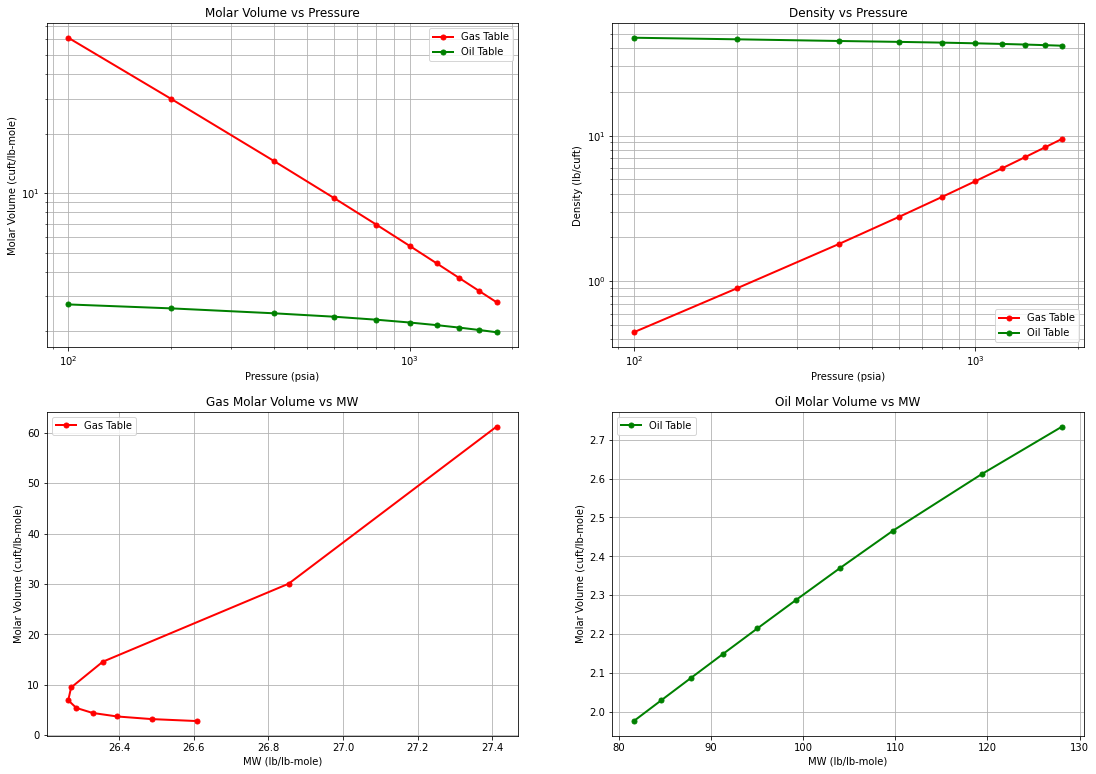

In [129]:
nx = 2                                                                                                                                 
ny = 2                                                                                                                            
dxs = 8.0                                                                                                                              
dys = 5.5                                                                                                                              
i = j = 0                  
fig, ax = plt.subplots(ny, nx, sharey = False, figsize=(dxs*nx, dys*ny), squeeze=False ) # squeeze = False ensures 2 x 1 does not get converted to 1D                                                                                
fig.subplots_adjust(top=0.95, bottom = 0.05, left = 0.05, right = 0.95)   
ax[i,j].title.set_text('Molar Volume vs Pressure')
ax[i,j].plot(PVT['P'], PVT['vg'], label='Gas Table', color='red', linewidth=2,marker='o',markersize=5)  
ax[i,j].plot(PVT['P'], PVT['vo'], label='Oil Table', color='green', linewidth=2,marker='o',markersize=5)   
ax[i,j].grid(True, which="both") 
ax[i,j].set_yscale('log')
ax[i,j].set_xscale('log')                                                                                                               
ax[i,j].set_xlabel('Pressure (psia)')                                                                                        
ax[i,j].set_ylabel('Molar Volume (cuft/lb-mole)')                                                                                                    
ax[i,j].legend()  

if j < nx-1:                                                                                                                       
    j+=1                                                                                                                                                                                                                                                 
else:                                                                                                                              
    j = 0                                                                                                                          
    i += 1

ax[i,j].title.set_text('Density vs Pressure')
ax[i,j].plot(PVT['P'], PVT['DENG'], label='Gas Table', color='red', linewidth=2,marker='o',markersize=5)  
ax[i,j].plot(PVT['P'], PVT['DENO'], label='Oil Table', color='green', linewidth=2,marker='o',markersize=5)   
ax[i,j].grid(True, which="both") 
ax[i,j].set_yscale('log')
ax[i,j].set_xscale('log')                                                                                                               
ax[i,j].set_xlabel('Pressure (psia)')                                                                                        
ax[i,j].set_ylabel('Density (lb/cuft)')                                                                                                    
ax[i,j].legend()  

if j < nx-1:                                                                                                                       
    j+=1                                                                                                                                                                                                                                                 
else:                                                                                                                              
    j = 0                                                                                                                          
    i += 1

ax[i,j].title.set_text('Gas Molar Volume vs MW')
ax[i,j].plot(PVT['MWg'],PVT['vg'] , label='Gas Table', color='red', linewidth=2,marker='o',markersize=5)  
ax[i,j].grid(True, which="both") 
#ax[i,j].set_yscale('log')
#ax[i,j].set_xscale('log')                                                                                                               
ax[i,j].set_xlabel('MW (lb/lb-mole)')                                                                                        
ax[i,j].set_ylabel('Molar Volume (cuft/lb-mole)')                                                                                                    
ax[i,j].legend()  

if j < nx-1:                                                                                                                       
    j+=1                                                                                                                                                                                                                                                 
else:                                                                                                                              
    j = 0                                                                                                                          
    i += 1

ax[i,j].title.set_text('Oil Molar Volume vs MW') 
ax[i,j].plot(PVT['MWo'],PVT['vo'] , label='Oil Table', color='green', linewidth=2,marker='o',markersize=5)   
ax[i,j].grid(True, which="both") 
#ax[i,j].set_yscale('log')
#ax[i,j].set_xscale('log')                                                                                                               
ax[i,j].set_xlabel('MW (lb/lb-mole)')                                                                                        
ax[i,j].set_ylabel('Molar Volume (cuft/lb-mole)')                                                                                                    
ax[i,j].legend()  

plt.show

## Save out extrapolated properties table

In [30]:
writer = pd.ExcelWriter("dataframe_out.xlsx", engine='xlsxwriter')
PVT.to_excel(writer,sheet_name = 'Table', index=False)
PVT_extrap.to_excel(writer,sheet_name = 'Extrap', index=False)
writer.save() 

In [9]:
PVT

,Rs,Bo,uo,OneOnBo,OneOnBouo,P,Rv,Bg,ug,OneOnBg,...,xo,xgi,yo,ygi,MWo,MWg,DENO,DENG,vo,vg
0,0.07947,1.084998,0.77114,0.921661,1.195192,100.0,0.014828,29.0620,0.010656,0.034409,...,0.906019,0.093981,0.011233,0.988767,128.119914,27.411772,46.862042,0.447700,2.733981,61.228027
1,0.15880,1.133572,0.70019,0.882167,1.259897,200.0,0.008249,14.1910,0.011304,0.070467,...,0.828311,0.171689,0.006280,0.993720,119.373866,26.854375,45.712779,0.893732,2.611389,30.047448
2,0.26530,1.193658,0.61741,0.837761,1.356896,400.0,0.002429,6.8519,0.011926,0.145945,...,0.742784,0.257216,0.001858,0.998142,109.747795,26.356634,44.506592,1.808656,2.465877,14.572501
3,0.34130,1.231743,0.55985,0.811858,1.450134,600.0,0.001443,4.4461,0.012384,0.224916,...,0.691808,0.308192,0.001104,0.998896,104.010522,26.271822,43.887637,2.776260,2.369928,9.463026
4,0.41360,1.266723,0.51250,0.789439,1.540368,800.0,0.001354,3.2535,0.012850,0.307361,...,0.649411,0.350589,0.001036,0.998964,99.238667,26.264181,43.376117,3.792562,2.287864,6.925181
5,0.48540,1.300841,0.47169,0.768733,1.629743,1000.0,0.001605,2.5442,0.013382,0.393051,...,0.612154,0.387846,0.001228,0.998772,95.045440,26.285775,42.915794,4.854814,2.214696,5.414373
6,0.55810,1.334993,0.43585,0.749068,1.718636,1200.0,0.002110,2.0765,0.014014,0.481580,...,0.578547,0.421453,0.001614,0.998386,91.262953,26.329171,42.486191,5.960409,2.148062,4.417343
7,0.63250,1.369635,0.40406,0.730122,1.806963,1400.0,0.002879,1.7472,0.014774,0.572344,...,0.547771,0.452229,0.002201,0.997799,87.799140,26.395262,42.078198,7.105745,2.086571,3.714637
8,0.70900,1.405054,0.37568,0.711716,1.894475,1600.0,0.003952,1.5048,0.015685,0.664540,...,0.519364,0.480636,0.003019,0.996981,84.601895,26.487310,41.685621,8.285934,2.029522,3.196659
9,0.78800,1.441473,0.35023,0.693735,1.980798,1800.0,0.005378,1.3207,0.016770,0.757174,...,0.492963,0.507037,0.004103,0.995897,81.630523,26.609345,41.304973,9.494782,1.976288,2.802523
